# Exploration avancée de l'équation de Kuramoto avec Fourier Neural Operators (FNO)

Dans ce notebook, nous plongeons dans une analyse approfondie de l'équation de Kuramoto avec coefficients variables, en utilisant des Fourier Neural Operators (FNO). Notre objectif est d'explorer la flexibilité et la robustesse de ces modèles face à différentes configurations et contextes temporels.

## Équation de Kuramoto avec coefficients

Nous étudions l'équation de Kuramoto sous la forme :

 $$u_t = -\gamma  uu_x - \beta  u_{xx} - \alpha  u_{xxxx}$$



## Expériences clés

1. **Entraînement sur coefficients multiples**
   - Construction de 4 jeux de données avec des coefficients différents
   
2. **Test de généralisation**
   - Fusion de 3 jeux de données
   - Évaluation de la capacité du modèle à prédire sur ce jeu fusionné

3. **Incorporation du contexte temporel**
   - Nouvelle structure de données : input = [u(t-2), u(t-1), u(t)]
   - Output : séquence [u(t+1), ..., u(t+20)]
   - Test de la performance du modèle avec ce contexte étendu



# Résultats

## 1. Prédiction avec coefficients multiples

Le modèle FNO a démontré une capacité à prédire les solutions de l'équation de Kuramoto-Sivashinsky (KS) pour différents jeux de coefficients. Cette performance suggère que le FNO est capable de capturer efficacement la dynamique non-linéaire complexe de l'équation KS, caractérisée par:

## 2. Test de généralisation sur jeux de données fusionnés

Lors de la fusion de deux jeux de données avec des coefficients différents, le modèle a montré des signes de difficulté, mais ses performances restent meilleures que prévu initialement. Cela suggère que :

1. **Robustesse partielle** : Le FNO a une certaine capacité à généraliser à travers différents régimes de l'équation KS.
2. **Limites de généralisation** : Il existe un seuil au-delà duquel le modèle commence à avoir des difficultés, probablement lorsque les dynamiques deviennent trop diverses.

3. **Contraintes techniques** : La limitation à deux jeux de données fusionnés due aux problèmes de RAM souligne un défi pratique dans l'entraînement de modèles sur des espaces de paramètres plus larges.

## 3. Incorporation du contexte temporel

L'ajout d'un contexte temporel étendu (utilisant [u(t-2), u(t-1), u(t)] comme entrée) présente plusieurs avantages rigoureux :

1. **Capture de la dynamique temporelle** : 
   - L'équation KS est un système dynamique où l'état futur dépend de l'historique récent.
   - L'inclusion de plusieurs pas de temps permet au modèle de mieux approximer la dérivée temporelle $u_t$.

2. **Réduction du problème de décorrélation temporelle** :
   - Dans les systèmes chaotiques comme KS, les prédictions à long terme sont intrinsèquement difficiles.
   - Un contexte temporel plus riche permet au modèle de mieux capturer les tendances à court terme, améliorant potentiellement la stabilité des prédictions à plus long terme.



3. **Analogie avec les méthodes numériques d'ordre supérieur** :
   - L'utilisation de plusieurs pas de temps est analogue aux schémas numériques multi-pas utilisés dans les méthodes classiques de résolution d'EDPs.
   - Cela permet potentiellement une meilleure approximation des dérivées temporelles.

Ces avantages théoriques se traduisent probablement par une amélioration des performances prédictives, en particulier pour les séquences plus longues [u(t+1), ..., u(t+20)]. Cependant, il serait intéressant de quantifier précisément ces améliorations par rapport à un modèle n'utilisant qu'un seul pas de temps en entrée.



In [1]:
import os
import sys
import random
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftfreq
from scipy.fftpack import diff as psdiff
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline


cuda


In [2]:
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SpectralConv1d(nn.Module):
  def __init__(self, in_channels, out_channels,modes):
    """
    modes : number of fourier modes kept
    """
    super(SpectralConv1d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes = modes
    self.scale = (1 / (in_channels*out_channels))

    self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.modes, dtype=torch.cfloat))

  def complex_mult1d(self, input, w):
    return torch.einsum('bix,iox->box',input,w)

  def forward(self, x):
    #compute the fourier coefficients
    x_ft = torch.fft.rfft(x)
    # Use only relevant fourier modes
    # need to perform some slicing to select only the relevant parts
    #The real-to-complex FFT reduces the last dimension (Nx) to Nx//2 + 1
    #due to the symmetry in the Fourier transform of real-valued signals.

    out = torch.zeros(x.shape[0],self.out_channels,x.size(-1)//2+1,dtype=torch.cfloat).to(x.device)

    out[:,:,:self.modes] = self.complex_mult1d(x_ft[:,:,:self.modes],self.weights)
    out = torch.fft.irfft(out,n=x.size(-1))
    return out



In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
  def __init__(self,modes,width,input_channels,output_channels):

    """
    The newtork consists of 4 Fourier Layers
    ->First we need to lift the input to the desired channel dim
    ->Then we apply the Fourier Layers
    ->Finally we need to project  the output back to the desired output space
    """
    super(FNO1d,self).__init__()

    self.modes = modes
    self.width = width
    self.input_channels = input_channels
    self.output_channels = output_channels
    #the output tensor from this layer will have a size of self.width
    #For now we will use a linear transformation
    self.lifting1 = nn.Conv1d(input_channels,self.width//2,1)
    self.lifting2 = nn.Conv1d(self.width//2,self.width,1)


    #define the Fourier Layers
    self.conv0 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv1 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv2 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv3 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv4 = SpectralConv1d(self.width,self.width,self.modes)
    #self.conv5 = SpectralConv1d(self.width,self.width,self.modes)

    #We still need to add the second half of the fourier layer which consists of

    #Mutliplying the input by a weight matrix and optionally adding a bias
    #We can either use conv1D or an MLP

    #Conv1d capture local features well but could miss out on capturing long-range
    #dependencies and complex nonlinear interactions that span the entire input space.

    ##MLP capture global interactions and complex relationships but might be less
    ## efficient and miss out on local detail refinements.

    ###In practice combining them both gives the best results
    self.w0 = nn.Conv1d(self.width, self.width, 1)
    self.w1 = nn.Conv1d(self.width, self.width,1)
    self.w2 = nn.Conv1d(self.width, self.width, 1)
    self.w3 = nn.Conv1d(self.width, self.width, 1)
    self.w4 = nn.Conv1d(self.width,self.width,1)
    #self.w5 = nn.Conv1d(self.width,self.width,1)

   

    #two layers to introduce non linearity
    self.projection1 = nn.Conv1d(self.width,self.width*2,1)
    self.projection2 = nn.Conv1d(self.width*2,output_channels,1)
    

  def forward(self,x):
      #First step : lift
      x = x.permute(0,2,1)
      x = self.lifting1(x)
      x = F.gelu(x)


      x = self.lifting2(x)
      x = F.gelu(x)
      # we need to permute because the next layer  expect the input to have the channels dimension second
      #x = x.permute(0,2,1)
      
      #2nd step : Fourier Layers
      x_skip = x
      x_0 = self.conv0(x)
      x_1 = self.w0(x)

      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv1(x)
      x_1 = self.w1(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv2(x)
      x_1 = self.w2(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip
      
      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 + x_skip
      

      #3rd step : projection
      #x = x.permute(0,2,1)
      x = self.projection1(x)
      x = F.gelu(x)
      x = self.projection2(x)
      if self.output_channels == 1:
        x = x.permute(0,2,1)

      return x





In [5]:

def sample_uniformly(inputs: np.ndarray, outputs: np.ndarray, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    total_samples = inputs.shape[0]
    sampled_indices = random.sample(range(total_samples), num_samples)
    sampled_inputs = inputs[sampled_indices]
    sampled_outputs = outputs[sampled_indices]
    return sampled_inputs, sampled_outputs

def load_dataset(output_dir, dataset_type):
    inputs = np.load(os.path.join(output_dir, f'{dataset_type}_inputs.npy'))
    outputs = np.load(os.path.join(output_dir, f'{dataset_type}_outputs.npy'))
    return inputs, outputs

def create_1_to_n_pairs(inputs, outputs, n):
    new_inputs = []
    new_outputs = []
    
    num_samples = inputs.shape[0]
    
    for i in range(num_samples - n + 1):
        new_inputs.append(inputs[i])
        new_outputs.append(outputs[i:i+n])
    
    new_inputs = np.array(new_inputs)
    new_outputs = np.array(new_outputs)
    
    return new_inputs, new_outputs


output_dir = './ks_data'

# Load the datasets
print("Loading datasets...")
train_inputs = np.load(os.path.join(output_dir, 'train_inputs_ex15.npy'))
train_outputs = np.load(os.path.join(output_dir, 'train_outputs_ex15.npy'))
val_inputs = np.load(os.path.join(output_dir, 'val_inputs_ex15.npy'))
val_outputs = np.load(os.path.join(output_dir, 'val_outputs_ex15.npy'))

# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs, dtype=torch.float32)

# Parameters
n = 20  # Number of successive steps


# Ensure correct dimensions and types
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation outputs shape: {val_outputs.shape}")


# Create 1-to-n pairs for the training set
train_inputs, train_outputs = create_1_to_n_pairs(train_inputs, train_outputs, n)
print(f"Created {train_inputs.shape[0]} 1-to-{n} pairs for training set.")

# Create 1-to-n pairs for the validation set
val_inputs, val_outputs = create_1_to_n_pairs(val_inputs, val_outputs, n)
print(f"Created {val_inputs.shape[0]} 1-to-{n} pairs for validation set.")


# Verify the new shapes
print(f"New train inputs shape: {train_inputs.shape}")
print(f"New train outputs shape: {train_outputs.shape}")
print(f"New val inputs shape: {val_inputs.shape}")
print(f"New val outputs shape: {val_outputs.shape}")









Loading datasets...
Converting numpy arrays to PyTorch tensors...
Train inputs shape: (300000, 256, 2)
Train outputs shape: (300000, 256)
Validation inputs shape: (40000, 256, 2)
Validation outputs shape: (40000, 256)
Created 299981 1-to-20 pairs for training set.
Created 39981 1-to-20 pairs for validation set.
New train inputs shape: (299981, 256, 2)
New train outputs shape: (299981, 20, 256)
New val inputs shape: (39981, 256, 2)
New val outputs shape: (39981, 20, 256)


In [6]:

num_samples_train = 50000
num_samples_val = 3000

# Uniformly sample 10,000 pairs from the training set
sampled_train_inputs, sampled_train_outputs = sample_uniformly(train_inputs, train_outputs, num_samples_train)


sampled_inputs_val, sampled_outputs_val = sample_uniformly(val_inputs, val_outputs, num_samples_val)


# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
sampled_train_inputs_tensor = torch.tensor(sampled_train_inputs, dtype=torch.float32)
sampled_train_outputs_tensor = torch.tensor(sampled_train_outputs, dtype=torch.float32)
sampled_val_inputs_tensor = torch.tensor(sampled_inputs_val, dtype=torch.float32)
sampled_val_outputs_tensor = torch.tensor(sampled_outputs_val, dtype=torch.float32)

# Create TensorDatasets
print("Creating TensorDatasets...")
train_dataset = TensorDataset(sampled_train_inputs_tensor, sampled_train_outputs_tensor)
val_dataset = TensorDataset(sampled_val_inputs_tensor, sampled_val_outputs_tensor)


# Create DataLoaders
batch_size = 50
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(sampled_train_inputs_tensor.shape)
print(sampled_train_outputs_tensor.shape)


Converting numpy arrays to PyTorch tensors...
Creating TensorDatasets...
Creating DataLoaders...
torch.Size([50000, 256, 2])
torch.Size([50000, 20, 256])


In [102]:



class SobolevLossFourier(nn.Module):
    def __init__(self, k=2):
        super(SobolevLossFourier, self).__init__()
        self.k = k

    def frequency_weights(self, nx):
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx)
        k_x = torch.abs(k_x)
        
        weights = torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            weights += k_x**(2 * i)
        return weights.unsqueeze(1)  

    def compute_loss(self, x, y):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        weights = self.frequency_weights(nx).to(x.device)
        weights = weights.repeat(1, nt, 1)  # Repeat for time dimension if necessary

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(weights * torch.abs(diff_fft)**2,)

        # Normalize by the energy of the target signal
        h1_loss = h1_loss / (torch.sum(weights * torch.abs(y_fft)**2) + 1e-8)

        return h1_loss.mean()

    def forward(self, pred, target):
        return self.compute_loss(pred, target)


class CombinedLoss(nn.Module):
    def __init__(self, sobolev_weight=1.0, mse_weight=0.1,k=1):
        super().__init__()
        self.sobolev_loss = SobolevLossFourier( k)
        self.mse_loss = nn.MSELoss()
        self.sobolev_weight = sobolev_weight
        self.mse_weight = mse_weight

    def forward(self, pred, target):
        sobolev = self.sobolev_loss(pred, target)
        mse = self.mse_loss(pred, target)
        return self.sobolev_weight * sobolev + self.mse_weight * mse



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

def train_fno(model, train_loader, val_loader, num_epochs, device ):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                
              
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Validation Loss: {val_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

# Configuration
num_epochs = 30



Case 2: Sequence prediction (t+1 to t+20)


In [11]:
model_sequence = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence = train_fno(model_sequence, train_loader, val_loader, num_epochs, device)
torch.save(model_sequence.state_dict(), 'fno_model_sequence_ex15.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30: 100%|██████████| 1000/1000 [00:31<00:00, 32.25it/s, train_loss=1.026026]



Epoch 1/30
Train Loss: 2.647582
Validation Loss: 1.018086



Epoch 2/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.56it/s, train_loss=0.046794]



Epoch 2/30
Train Loss: 0.389036
Validation Loss: 0.042788



Epoch 3/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s, train_loss=0.020138]



Epoch 3/30
Train Loss: 0.028158
Validation Loss: 0.018360



Epoch 4/30: 100%|██████████| 1000/1000 [00:32<00:00, 31.14it/s, train_loss=0.009157]



Epoch 4/30
Train Loss: 0.014477
Validation Loss: 0.007616



Epoch 5/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.75it/s, train_loss=0.002995]



Epoch 5/30
Train Loss: 0.004851
Validation Loss: 0.001967



Epoch 6/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.25it/s, train_loss=0.000863]



Epoch 6/30
Train Loss: 0.002116
Validation Loss: 0.000748



Epoch 7/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s, train_loss=0.000838]



Epoch 7/30
Train Loss: 0.001527
Validation Loss: 0.000488



Epoch 8/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.49it/s, train_loss=0.000916]



Epoch 8/30
Train Loss: 0.001372
Validation Loss: 0.000412



Epoch 9/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.43it/s, train_loss=0.000801]



Epoch 9/30
Train Loss: 0.001229
Validation Loss: 0.000281



Epoch 10/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.24it/s, train_loss=0.000323]



Epoch 10/30
Train Loss: 0.001025
Validation Loss: 0.000207



Epoch 11/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s, train_loss=0.000220]



Epoch 11/30
Train Loss: 0.000891
Validation Loss: 0.000146



Epoch 12/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.62it/s, train_loss=0.000972]



Epoch 12/30
Train Loss: 0.000738
Validation Loss: 0.000840



Epoch 13/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.89it/s, train_loss=0.000151]



Epoch 13/30
Train Loss: 0.000638
Validation Loss: 0.000114



Epoch 14/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.89it/s, train_loss=0.000139]



Epoch 14/30
Train Loss: 0.000549
Validation Loss: 0.000099



Epoch 15/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.46it/s, train_loss=0.000125]



Epoch 15/30
Train Loss: 0.000473
Validation Loss: 0.000093



Epoch 16/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.86it/s, train_loss=0.001007]



Epoch 16/30
Train Loss: 0.000397
Validation Loss: 0.001742



Epoch 17/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.73it/s, train_loss=0.000097]



Epoch 17/30
Train Loss: 0.000383
Validation Loss: 0.000083



Epoch 18/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.49it/s, train_loss=0.000222]



Epoch 18/30
Train Loss: 0.000314
Validation Loss: 0.000129



Epoch 19/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.09it/s, train_loss=0.000136]



Epoch 19/30
Train Loss: 0.000278
Validation Loss: 0.000105



Epoch 20/30: 100%|██████████| 1000/1000 [00:33<00:00, 30.30it/s, train_loss=0.000077]



Epoch 20/30
Train Loss: 0.000261
Validation Loss: 0.000066



Epoch 21/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.48it/s, train_loss=0.000066]



Epoch 21/30
Train Loss: 0.000249
Validation Loss: 0.000069



Epoch 22/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s, train_loss=0.000064]



Epoch 22/30
Train Loss: 0.000239
Validation Loss: 0.000056



Epoch 23/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.89it/s, train_loss=0.000052]



Epoch 23/30
Train Loss: 0.000228
Validation Loss: 0.000052



Epoch 24/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.69it/s, train_loss=0.000061]



Epoch 24/30
Train Loss: 0.000218
Validation Loss: 0.000050



Epoch 25/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.62it/s, train_loss=0.000050]



Epoch 25/30
Train Loss: 0.000213
Validation Loss: 0.000049



Epoch 26/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.07it/s, train_loss=0.000051]



Epoch 26/30
Train Loss: 0.000209
Validation Loss: 0.000048



Epoch 27/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.76it/s, train_loss=0.000056]



Epoch 27/30
Train Loss: 0.000204
Validation Loss: 0.000047



Epoch 28/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.81it/s, train_loss=0.000060]



Epoch 28/30
Train Loss: 0.000201
Validation Loss: 0.000049



Epoch 29/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.32it/s, train_loss=0.000054]



Epoch 29/30
Train Loss: 0.000199
Validation Loss: 0.000047



Epoch 30/30: 100%|██████████| 1000/1000 [00:25<00:00, 38.47it/s, train_loss=0.000051]



Epoch 30/30
Train Loss: 0.000198
Validation Loss: 0.000046



Test

In [33]:
# Parameters
L = 100
N = 256
T = 100

test_initial_conditions = np.load(os.path.join(output_dir, 'test_inputs_ex15.npy'))
test_solutions = np.load(os.path.join(output_dir, 'test_outputs_ex15.npy'))


Evaluating long sequence prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_3888\3030996324.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sequence.load_state_dict(torch.load('fno_model_

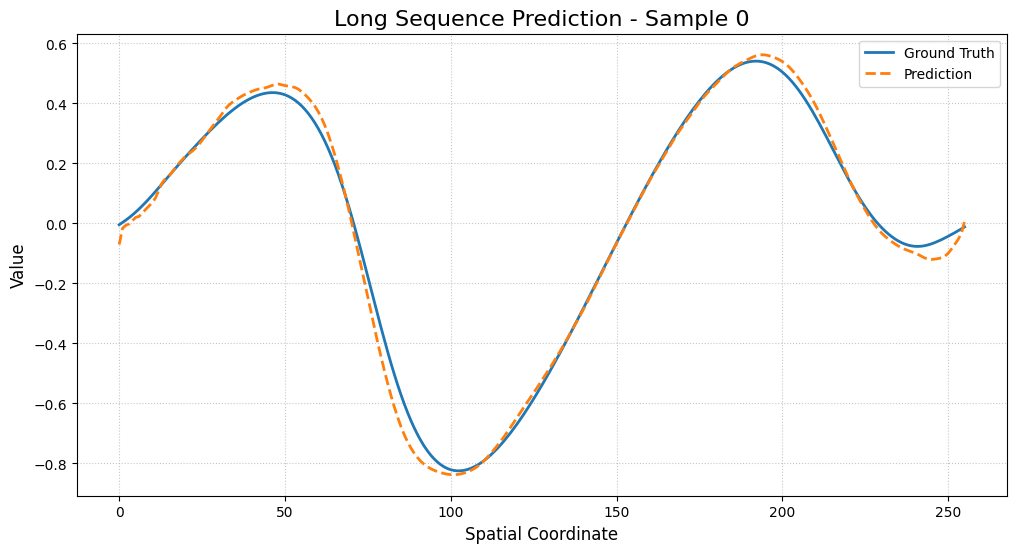

In [36]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device):
    test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
    test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)
    test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

def load_model(model_path, device):
    model = FNO1d(modes=32, width=64, input_channels=2, output_channels=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_long_sequence(model, inputs, time_steps_to_predict, device):
    predictions = []
    grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
    current_input = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
    
    with torch.no_grad():
        while len(predictions) * 20 < time_steps_to_predict:
            outputs = model(current_input).squeeze().cpu().numpy()
            predictions.append(outputs)
            last_output = outputs[-1]
            last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(-1)
            current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)
    
    return np.concatenate(predictions, axis=0)[:time_steps_to_predict]

def predict_single_step(model, inputs, device):
    with torch.no_grad():
        grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        return model(inputs).squeeze().cpu().numpy()

def plot_comparison(ground_truth, prediction, title, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth, label="Ground Truth", linewidth=2)
    plt.plot(prediction, label="Prediction", linewidth=2, linestyle='--')
    plt.title(title, fontsize=16)
    plt.xlabel("Spatial Coordinate", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_error_heatmap(ground_truth, predictions, title, save_path=None):
    error = np.abs(ground_truth - predictions)
    plt.figure(figsize=(12, 6))
    sns.heatmap(error.T, cmap='viridis', cbar_kws={'label': 'Absolute Error'})
    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Spatial Coordinate", fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()





time_steps_to_predict = 100
# Long sequence prediction
print("Evaluating long sequence prediction...")
test_loader_sequence = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)
model_sequence= FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
model_sequence.load_state_dict(torch.load('fno_model_sequence_ex15.pth'))
model_sequence.eval()
all_predictions_long = []
all_targets_long = []

for inputs, targets in test_loader_sequence:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_long_sequence(model_sequence, inputs,time_steps_to_predict, device)
    all_predictions_long.append(predictions[-1])
    all_targets_long.append(targets.squeeze().cpu().numpy())

all_predictions_long = np.array(all_predictions_long)
all_targets_long = np.array(all_targets_long)

for idx in range(1):
    plot_comparison(all_targets_long[idx], all_predictions_long[idx], 
                    f"Long Sequence Prediction - Sample {idx}", 
                    f"long_sequence_comparison_{idx}.png")





**FUSION**

Le code suivant implémente une stratégie efficace pour fusionner plusieurs jeux de données de l'équation de Kuramoto

In [25]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
from torch.utils.data import Dataset, DataLoader, Sampler


class KSDataset(Dataset):
    def __init__(self, data_dir, suffixes, n):
        self.data_dir = data_dir
        self.suffixes = suffixes
        self.n = n
        self.file_sizes = []
        self.cumulative_sizes = [0]

        for suffix in suffixes:
            inputs = np.load(os.path.join(data_dir, f'train_inputs_ex{suffix}.npy'), mmap_mode='r')
            self.file_sizes.append(inputs.shape[0] - n + 1)
            self.cumulative_sizes.append(self.cumulative_sizes[-1] + self.file_sizes[-1])

        self.total_size = self.cumulative_sizes[-1]

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        file_idx = np.searchsorted(self.cumulative_sizes, idx, side='right') - 1
        local_idx = idx - self.cumulative_sizes[file_idx]
        
        suffix = self.suffixes[file_idx]
        inputs = np.load(os.path.join(self.data_dir, f'train_inputs_ex{suffix}.npy'), mmap_mode='r')
        outputs = np.load(os.path.join(self.data_dir, f'train_outputs_ex{suffix}.npy'), mmap_mode='r')
        
        input_data = inputs[local_idx]
        output_data = outputs[local_idx:local_idx+self.n]
        
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(output_data, dtype=torch.float32)


class ShuffledSampler(Sampler):
    def __init__(self, data_source, num_samples=None):
        self.data_source = data_source
        self.num_samples = num_samples if num_samples is not None else len(data_source)

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source))
        return iter(indices[:self.num_samples])

    def __len__(self):
        return self.num_samples

def create_combined_dataloader(data_dir, suffixes, n, batch_size, num_samples):
    dataset = KSDataset(data_dir, suffixes, n)
    
    if num_samples is not None and num_samples < len(dataset):
        sampler = ShuffledSampler(dataset, num_samples)
    else:
        sampler = ShuffledSampler(dataset)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    
    return dataloader


# Usage
output_dir = './ks_data'
suffixes = [ '15', '16','17']
n = 20  # Number of successive steps
batch_size = 50
num_samples_train = 50000  # Set to None if you  to use all available data

train_loader = create_combined_dataloader(output_dir, suffixes, n, batch_size, num_samples_train)

print("Dataset combination and processing complete.")
print(f"Number of batches: {len(train_loader)}")

Dataset combination and processing complete.
Number of batches: 1000


In [26]:
model_sequence_fusion= FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence_fusion = train_fno(model_sequence, train_loader, val_loader, num_epochs, device)
torch.save(model_sequence_fusion.state_dict(), 'fno_model_sequence_fusion.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s, train_loss=0.003338]



Epoch 1/30
Train Loss: 0.004026
Validation Loss: 0.001758



Epoch 2/30: 100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s, train_loss=0.072746]



Epoch 2/30
Train Loss: 0.003005
Validation Loss: 0.001213



Epoch 3/30: 100%|██████████| 1000/1000 [01:16<00:00, 13.07it/s, train_loss=0.001493]



Epoch 3/30
Train Loss: 0.002749
Validation Loss: 0.000979



Epoch 4/30: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s, train_loss=0.001420]



Epoch 4/30
Train Loss: 0.002282
Validation Loss: 0.000919



Epoch 5/30: 100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s, train_loss=0.001534]



Epoch 5/30
Train Loss: 0.002244
Validation Loss: 0.000811



Epoch 6/30: 100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s, train_loss=0.001025]



Epoch 6/30
Train Loss: 0.001810
Validation Loss: 0.000828



Epoch 7/30: 100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s, train_loss=0.001154]



Epoch 7/30
Train Loss: 0.001730
Validation Loss: 0.000771



Epoch 8/30: 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s, train_loss=0.000828]



Epoch 8/30
Train Loss: 0.002122
Validation Loss: 0.000588



Epoch 9/30: 100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s, train_loss=0.000758]



Epoch 9/30
Train Loss: 0.001572
Validation Loss: 0.000620



Epoch 10/30: 100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s, train_loss=0.001238]



Epoch 10/30
Train Loss: 0.001445
Validation Loss: 0.000911



Epoch 11/30: 100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s, train_loss=0.000652]



Epoch 11/30
Train Loss: 0.001494
Validation Loss: 0.000552



Epoch 12/30: 100%|██████████| 1000/1000 [01:11<00:00, 13.89it/s, train_loss=0.000716]



Epoch 12/30
Train Loss: 0.001451
Validation Loss: 0.000538



Epoch 13/30: 100%|██████████| 1000/1000 [01:11<00:00, 13.94it/s, train_loss=0.000974]



Epoch 13/30
Train Loss: 0.001707
Validation Loss: 0.000625



Epoch 14/30: 100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s, train_loss=0.000692]



Epoch 14/30
Train Loss: 0.001549
Validation Loss: 0.000461



Epoch 15/30: 100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s, train_loss=0.000551]



Epoch 15/30
Train Loss: 0.001328
Validation Loss: 0.000387



Epoch 16/30: 100%|██████████| 1000/1000 [01:10<00:00, 14.23it/s, train_loss=0.000620]



Epoch 16/30
Train Loss: 0.001176
Validation Loss: 0.000387



Epoch 17/30: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s, train_loss=0.000559]



Epoch 17/30
Train Loss: 0.001533
Validation Loss: 0.000465



Epoch 18/30: 100%|██████████| 1000/1000 [01:14<00:00, 13.35it/s, train_loss=0.000770]



Epoch 18/30
Train Loss: 0.001198
Validation Loss: 0.000602



Epoch 19/30: 100%|██████████| 1000/1000 [01:17<00:00, 12.93it/s, train_loss=0.000541]



Epoch 19/30
Train Loss: 0.000864
Validation Loss: 0.000467



Epoch 20/30: 100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s, train_loss=0.001234]



Epoch 20/30
Train Loss: 0.001074
Validation Loss: 0.000624



Epoch 21/30: 100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s, train_loss=0.000436]



Epoch 21/30
Train Loss: 0.000961
Validation Loss: 0.000368



Epoch 22/30: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s, train_loss=0.000532]



Epoch 22/30
Train Loss: 0.000659
Validation Loss: 0.000310



Epoch 23/30: 100%|██████████| 1000/1000 [01:09<00:00, 14.44it/s, train_loss=0.000400]



Epoch 23/30
Train Loss: 0.000999
Validation Loss: 0.000354



Epoch 24/30: 100%|██████████| 1000/1000 [01:10<00:00, 14.22it/s, train_loss=0.000539]



Epoch 24/30
Train Loss: 0.000844
Validation Loss: 0.000311



Epoch 25/30: 100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s, train_loss=0.000449]



Epoch 25/30
Train Loss: 0.000964
Validation Loss: 0.000370



Epoch 26/30: 100%|██████████| 1000/1000 [01:10<00:00, 14.10it/s, train_loss=0.000559]



Epoch 26/30
Train Loss: 0.000900
Validation Loss: 0.000303



Epoch 27/30: 100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s, train_loss=0.000342]



Epoch 27/30
Train Loss: 0.001093
Validation Loss: 0.000323



Epoch 28/30: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s, train_loss=0.000408]



Epoch 28/30
Train Loss: 0.001126
Validation Loss: 0.000336



Epoch 29/30: 100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s, train_loss=0.000446]



Epoch 29/30
Train Loss: 0.000538
Validation Loss: 0.000327



Epoch 30/30: 100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s, train_loss=0.000425]



Epoch 30/30
Train Loss: 0.000965
Validation Loss: 0.000320



In [32]:
# Generate test dataset


def generate_params() -> Tuple[int, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns parameters for initial conditions.
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0 * np.pi * np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return N, A, phi, l

def initial_conditions(x: np.ndarray, L: int, params: Optional[list] = None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L) + phi), -1)
    return u

def pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for KS equation using Fourier transform.
    """
    u_x = psdiff(u, period=L)
    u_xx = psdiff(u, period=L, order=2)
    u_xxxx = psdiff(u, period=L, order=4)
    uu_x = u * u_x

    dudt = -uu_x - u_xx - u_xxxx
    return dudt

def generate_dataset_test(num_samples: int, L: int, N: int, T: float, tol: float, output_dir: str):
    x = np.linspace(0,  L, N)
    t = np.arange(0, T+0.05, 0.05)

    initial_conditions_list = []
    solutions_list = []

    for i in range(num_samples):
        u0 = initial_conditions(x, L)
        sol_ps = solve_ivp(fun=pseudospectral, t_span=[t[0], t[-1]], y0=u0, method='Radau', t_eval=t, args=(L,), atol=tol, rtol=tol)
        initial_conditions_list.append(u0)
        solutions_list.append(sol_ps.y.T)
        if i % 10 == 0:
            print(f"Generated {i} samples")

    initial_conditions_array = np.array(initial_conditions_list)
    max_len = max([sol.shape[0] for sol in solutions_list])
    solutions_array = np.zeros((num_samples, max_len, N))
    for i, sol in enumerate(solutions_list):
        solutions_array[i, :sol.shape[0], :] = sol

    return initial_conditions_array, solutions_array



# Parameters
L = 100
N = 256
T = 100
tol = 1e-6
num_samples = 1
test_initial_conditions, test_solutions = generate_dataset_test(num_samples, L, N, T, tol, output_dir)
# Generate validation dataset
#aggregate_datasets(1, 100, dt, L, N, output_dir, 'test')
#test_inputs = np.load(os.path.join(output_dir, 'test_inputs.npy'))
#test_outputs = np.load(os.path.join(output_dir, 'test_outputs.npy'))

#sampled_inputs_test, sampled_outputs_test = sample_uniformly(test_inputs, test_outputs, 1)





Generated 0 samples


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_3888\957026177.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sequence.load_state_dict(torch.load('fno_model_se

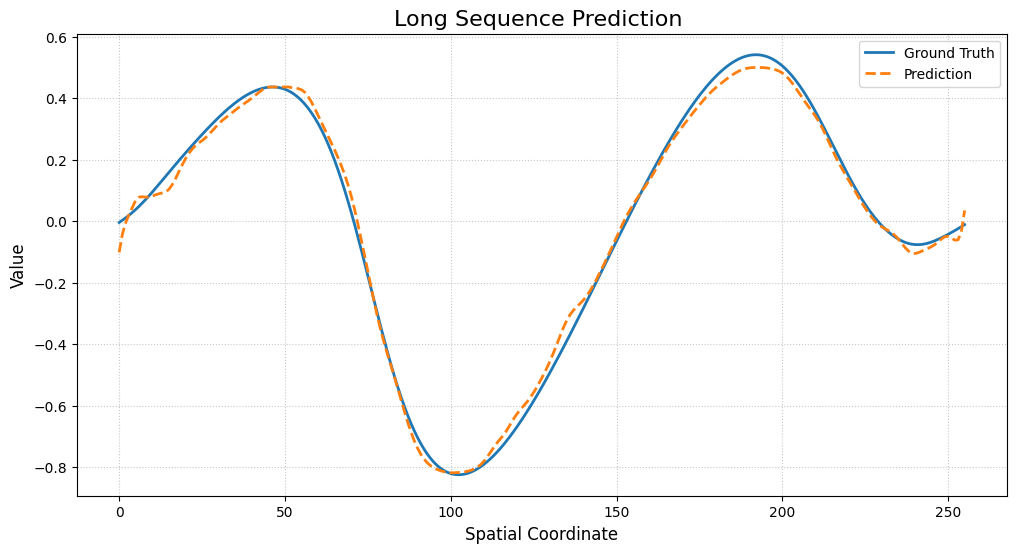

In [35]:
time_steps_to_predict = 100
# Long sequence prediction
test_loader_sequence = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)

model_sequence = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
model_sequence.load_state_dict(torch.load('fno_model_sequence_fusion.pth'))
model_sequence.eval()
all_predictions_long = []
all_targets_long = []

for inputs, targets in test_loader_sequence:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_long_sequence(model_sequence, inputs,time_steps_to_predict, device)
    all_predictions_long.append(predictions[-1])
    all_targets_long.append(targets.squeeze().cpu().numpy())

all_predictions_long = np.array(all_predictions_long)
all_targets_long = np.array(all_targets_long)

for idx in range(1):
    plot_comparison(all_targets_long[idx], all_predictions_long[idx], 
                    f"Long Sequence Prediction ", 
                    f"long_sequence_comparison.png")




# L'utilisation d'un contexte temporel

L'incorporation d'un contexte temporel étendu (t-2, t-1, t) dans notre modèle FNO pour l'équation de Kuramoto est motivée par la nature dynamique et non-linéaire du système. En fournissant au modèle des informations sur les états précédents, nous lui permettons de capturer des tendances et des motifs d'évolution qui pourraient ne pas être apparents en ne considérant qu'un seul instant. 

In [37]:
# Load the datasets
print("Loading datasets...")
train_inputs = np.load(os.path.join(output_dir, 'train_inputs_ex1_multi.npy'))
train_outputs = np.load(os.path.join(output_dir, 'train_outputs_ex1_multi.npy'))
#val_inputs = np.load(os.path.join(output_dir, 'val_inputs_ex1_multi.npy'))
#val_outputs = np.load(os.path.join(output_dir, 'val_outputs_ex1_multi.npy'))

# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs, dtype=torch.float32)



# Ensure correct dimensions and types
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")





# Verify the new shapes
print(f"New train inputs shape: {train_inputs.shape}")
print(f"New train outputs shape: {train_outputs.shape}")

num_samples_train = 50000
num_samples_val = 1000


# Uniformly sample 10,000 pairs from the training set
sampled_train_inputs, sampled_train_outputs = sample_uniformly(train_inputs, train_outputs, num_samples_train)




# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
sampled_train_inputs_tensor = torch.tensor(sampled_train_inputs, dtype=torch.float32)
sampled_train_outputs_tensor = torch.tensor(sampled_train_outputs, dtype=torch.float32)
#sampled_val_inputs_tensor = torch.tensor(sampled_inputs_val, dtype=torch.float32)
#sampled_val_outputs_tensor = torch.tensor(sampled_outputs_val, dtype=torch.float32)

# Create TensorDatasets
print("Creating TensorDatasets...")
train_dataset = TensorDataset(sampled_train_inputs_tensor, sampled_train_outputs_tensor)
#val_dataset = TensorDataset(sampled_val_inputs_tensor, sampled_val_outputs_tensor)




# Create DataLoaders
batch_size = 50
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading datasets...
Converting numpy arrays to PyTorch tensors...
Train inputs shape: (124895, 256, 4)
Train outputs shape: (124895, 20, 256)
New train inputs shape: (124895, 256, 4)
New train outputs shape: (124895, 20, 256)
Converting numpy arrays to PyTorch tensors...
Creating TensorDatasets...
Creating DataLoaders...


In [105]:
def train_fno_context(model, train_loader, num_epochs, device ):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
       
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

def train_fno_context_combined(model, train_loader, num_epochs, device ):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = CombinedLoss(1,1,k=1)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
       
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

In [76]:
model_sequence_context= FNO1d(modes=32, width=64,input_channels=4,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence_context = train_fno_context(model_sequence_context, train_loader ,num_epochs, device)
torch.save(model_sequence_context.state_dict(), 'fno_model_sequence_context.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s, train_loss=6.108315]

Epoch 1/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.80it/s, train_loss=1.420377]



Epoch 1/30
Train Loss: 2.443449



Epoch 2/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.34it/s, train_loss=0.280037]



Epoch 2/30
Train Loss: 0.564579



Epoch 3/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.42it/s, train_loss=0.067257]



Epoch 3/30
Train Loss: 0.172379



Epoch 4/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.43it/s, train_loss=0.013881]



Epoch 4/30
Train Loss: 0.031779



Epoch 5/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.16it/s, train_loss=0.004597]



Epoch 5/30
Train Loss: 0.009149



Epoch 6/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.19it/s, train_loss=0.001895]



Epoch 6/30
Train Loss: 0.004479



Epoch 7/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.32it/s, train_loss=0.002475]



Epoch 7/30
Train Loss: 0.002831



Epoch 8/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.32it/s, train_loss=0.000990]



Epoch 8/30
Train Loss: 0.002129



Epoch 9/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.49it/s, train_loss=0.000903]



Epoch 9/30
Train Loss: 0.001632



Epoch 10/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.98it/s, train_loss=0.000977]



Epoch 10/30
Train Loss: 0.001572



Epoch 11/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.52it/s, train_loss=0.001000]



Epoch 11/30
Train Loss: 0.000966



Epoch 12/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.93it/s, train_loss=0.000958]



Epoch 12/30
Train Loss: 0.001040



Epoch 13/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.62it/s, train_loss=0.000760]



Epoch 13/30
Train Loss: 0.000798



Epoch 14/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.31it/s, train_loss=0.000828]



Epoch 14/30
Train Loss: 0.000611



Epoch 15/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.24it/s, train_loss=0.000418]



Epoch 15/30
Train Loss: 0.000574



Epoch 16/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.00it/s, train_loss=0.000345]



Epoch 16/30
Train Loss: 0.000494



Epoch 17/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s, train_loss=0.000350]



Epoch 17/30
Train Loss: 0.000451



Epoch 18/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.47it/s, train_loss=0.000288]



Epoch 18/30
Train Loss: 0.000371



Epoch 19/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.36it/s, train_loss=0.000560]



Epoch 19/30
Train Loss: 0.000331



Epoch 20/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.12it/s, train_loss=0.000190]



Epoch 20/30
Train Loss: 0.000296



Epoch 21/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.41it/s, train_loss=0.000347]



Epoch 21/30
Train Loss: 0.000275



Epoch 22/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.41it/s, train_loss=0.000184]



Epoch 22/30
Train Loss: 0.000252



Epoch 23/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s, train_loss=0.000268]



Epoch 23/30
Train Loss: 0.000235



Epoch 24/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.90it/s, train_loss=0.000298]



Epoch 24/30
Train Loss: 0.000236



Epoch 25/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.79it/s, train_loss=0.000192]



Epoch 25/30
Train Loss: 0.000221



Epoch 26/30: 100%|██████████| 1000/1000 [00:27<00:00, 37.00it/s, train_loss=0.000169]



Epoch 26/30
Train Loss: 0.000220



Epoch 27/30: 100%|██████████| 1000/1000 [00:27<00:00, 37.04it/s, train_loss=0.000205]



Epoch 27/30
Train Loss: 0.000204



Epoch 28/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.04it/s, train_loss=0.000148]



Epoch 28/30
Train Loss: 0.000198



Epoch 29/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.69it/s, train_loss=0.000177]



Epoch 29/30
Train Loss: 0.000195



Epoch 30/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.53it/s, train_loss=0.000226]


Epoch 30/30
Train Loss: 0.000193



In [106]:
model_sequence_context_combined= FNO1d(modes=32, width=64,input_channels=4,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence_context_combined = train_fno_context_combined(model_sequence_context_combined, train_loader ,num_epochs, device)
torch.save(model_sequence_context.state_dict(), 'fno_model_sequence_context_combined.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.42it/s, train_loss=1.960556]



Epoch 1/30
Train Loss: 3.250417



Epoch 2/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.53it/s, train_loss=0.232068]



Epoch 2/30
Train Loss: 0.771385



Epoch 3/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.99it/s, train_loss=0.066194]



Epoch 3/30
Train Loss: 0.142251



Epoch 4/30: 100%|██████████| 1000/1000 [00:38<00:00, 26.31it/s, train_loss=0.017476]



Epoch 4/30
Train Loss: 0.034773



Epoch 5/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s, train_loss=0.007061]



Epoch 5/30
Train Loss: 0.011579



Epoch 6/30: 100%|██████████| 1000/1000 [00:32<00:00, 31.12it/s, train_loss=0.003542]



Epoch 6/30
Train Loss: 0.004909



Epoch 7/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s, train_loss=0.009654]



Epoch 7/30
Train Loss: 0.003331



Epoch 8/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.78it/s, train_loss=0.001357]



Epoch 8/30
Train Loss: 0.002674



Epoch 9/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s, train_loss=0.001018]



Epoch 9/30
Train Loss: 0.002090



Epoch 10/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.94it/s, train_loss=0.001390]



Epoch 10/30
Train Loss: 0.001705



Epoch 11/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.44it/s, train_loss=0.001639]



Epoch 11/30
Train Loss: 0.001463



Epoch 12/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.27it/s, train_loss=0.001350]



Epoch 12/30
Train Loss: 0.001316



Epoch 13/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.89it/s, train_loss=0.000623]



Epoch 13/30
Train Loss: 0.001050



Epoch 14/30: 100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s, train_loss=0.000818]



Epoch 14/30
Train Loss: 0.000942



Epoch 15/30: 100%|██████████| 1000/1000 [00:40<00:00, 24.89it/s, train_loss=0.000698]



Epoch 15/30
Train Loss: 0.000800



Epoch 16/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.46it/s, train_loss=0.000662]



Epoch 16/30
Train Loss: 0.000682



Epoch 17/30: 100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s, train_loss=0.000407]



Epoch 17/30
Train Loss: 0.000615



Epoch 18/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.47it/s, train_loss=0.000450]



Epoch 18/30
Train Loss: 0.000523



Epoch 19/30: 100%|██████████| 1000/1000 [00:33<00:00, 30.10it/s, train_loss=0.000503]



Epoch 19/30
Train Loss: 0.000469



Epoch 20/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.48it/s, train_loss=0.000382]



Epoch 20/30
Train Loss: 0.000416



Epoch 21/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.51it/s, train_loss=0.000431]



Epoch 21/30
Train Loss: 0.000375



Epoch 22/30: 100%|██████████| 1000/1000 [00:34<00:00, 29.13it/s, train_loss=0.000520]



Epoch 22/30
Train Loss: 0.000353



Epoch 23/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.80it/s, train_loss=0.000255]



Epoch 23/30
Train Loss: 0.000328



Epoch 24/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s, train_loss=0.000323]



Epoch 24/30
Train Loss: 0.000307



Epoch 25/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.39it/s, train_loss=0.000342]



Epoch 25/30
Train Loss: 0.000295



Epoch 26/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.98it/s, train_loss=0.000263]



Epoch 26/30
Train Loss: 0.000284



Epoch 27/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.80it/s, train_loss=0.000281]



Epoch 27/30
Train Loss: 0.000275



Epoch 28/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.89it/s, train_loss=0.000343]



Epoch 28/30
Train Loss: 0.000269



Epoch 29/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.27it/s, train_loss=0.000246]



Epoch 29/30
Train Loss: 0.000265



Epoch 30/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.03it/s, train_loss=0.000228]


Epoch 30/30
Train Loss: 0.000264



C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_3888\2290516242.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( 'fno_model_sequence

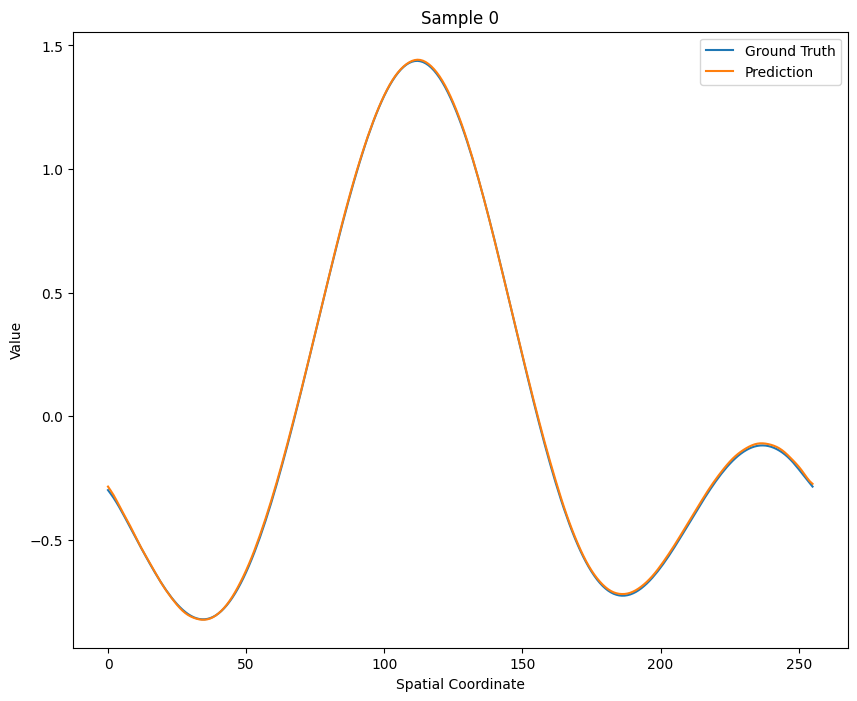

In [113]:
test_initial_conditions = np.load(os.path.join(output_dir, 'test_inputs_multi.npy'))
test_solutions = np.load(os.path.join(output_dir, 'test_outputs_multi.npy'))

time_steps_to_predict =1

test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)  # Solution at the final desired time step

test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = FNO1d(modes=32, width=64,input_channels=4,output_channels=20).to(device)

model.load_state_dict(torch.load( 'fno_model_sequence_context.pth'))

model.to(device)
model.eval()

all_predictions_1 = []
all_targets_1 = []
all_inputs_1 = []
all_pred = []

with torch.no_grad():
   for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        grid = torch.linspace(0, L, inputs.shape[-1]).unsqueeze(0).unsqueeze(1).to(device)
        inputs = torch.cat((inputs, grid), dim=1)

        predictions = []
        current_input = inputs
        
        while len(predictions) * 20 < time_steps_to_predict:
           
            current_input = current_input.permute(0, 2, 1)
            outputs = model(current_input)
            outputs = outputs.squeeze().cpu().numpy()
            predictions.append(outputs)
            # Prepare for next iteration
            last_output = outputs[-3:]
            last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device)
            last_output_tensor = last_output_tensor.unsqueeze(0)  # Add batch and channel dimensions
            current_input = torch.cat((last_output_tensor, grid), dim=1)

        predictions = np.concatenate(predictions, axis=0)[:time_steps_to_predict]
        targets = targets.squeeze().cpu().numpy()
        inputs = inputs.squeeze().cpu().numpy()
        all_inputs_1.append(inputs)
        all_predictions_1.append(predictions[-1])  # Only the final prediction
        all_targets_1.append(targets)
        all_pred.append(predictions)

all_predictions_1 = np.array(all_predictions_1)
all_targets_1 = np.array(all_targets_1)


# Plot the results
for idx in range(1):  
    plt.figure(figsize=(10, 8))
    plt.plot(all_targets_1[idx], label="Ground Truth")
    plt.plot(all_predictions_1[idx], label="Prediction")
    plt.title(f"Sample {idx}")
    plt.xlabel("Spatial Coordinate")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
